In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
np.random.seed(42)
import pprint
from matplotlib import pyplot as plt

import sys
sys.path.append("../../")
from qolmat.benchmark import comparator
from qolmat.imputations import models
from qolmat.utils import data
from qolmat.imputations.em_sampler import ImputeEM

### **I. Load data**

In [41]:
download = True
dataset = data.get_data(download=download)
if download:
    cols_to_impute = ["TEMP", "PRES", "DEWP"]
else:
    cols_to_impute = ["var"]

dataset.reset_index(inplace=True)
dataset.set_index(["station", "datetime"], inplace=True)
dataset.head()

PM2.5        PM10        SO2        NO2           CO  \
station datetime                                                                
Gucheng 2013-03-01    8.625000   16.875000   7.391304  14.250000   869.565217   
        2013-03-02   36.916667   51.375000  37.291667  37.565217  1479.041667   
        2013-03-03   80.333333  120.041667  47.541667  63.333333  2349.708333   
        2013-03-04   26.500000   51.291667  18.666667  32.666667  1170.666667   
        2013-03-05  136.708333  172.541667  75.130435  73.500000  1381.545455   

                           O3      TEMP         PRES       DEWP  RAIN  \
station datetime                                                        
Gucheng 2013-03-01  77.130435  1.691667  1024.816667 -19.691667   0.0   
        2013-03-02  39.583333  0.820833  1024.900000 -16.337500   0.0   
        2013-03-03  33.708333  6.562500  1012.566667 -11.991667   0.0   
        2013-03-04  67.250000  9.795833  1015.608333 -11.945833   0.0   
        2013-03-05  84.375000  6.750000  1008.883333  -7.741667   0.0   

                        WSPM  
station datetime              
Gucheng 2013-03-01  2.350000  
        2013-03-02  1.087500  
        2013-03-03  1.400000  
        2013-03-04  1.541667  
        2013-03-05  0.841667

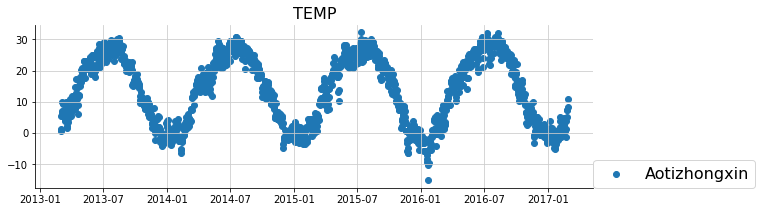

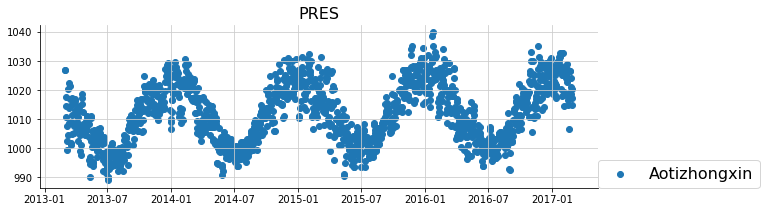

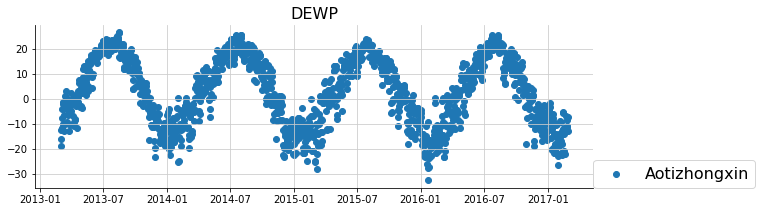

In [42]:
for col in cols_to_impute:
    plt.figure(figsize=(10, 3))
    for station, df in dataset.groupby("station"):
        plt.scatter(df.reset_index().datetime, df[col], label=station)
        break
    plt.title(col, fontsize=16)
    plt.legend(loc=[1, 0], fontsize=16)
    plt.show()

### **II. Corruption**

In [43]:
df_corrupted = df[cols_to_impute].copy()

p = 0.6
mask_temp = np.random.choice(a=[False, True], size=(len(df_corrupted),), p=[0.85, 0.15])
mask_pres = np.random.choice(a=[False, True], size=(len(df_corrupted),), p=[0.65, 0.35])
mask_dewp = (df_corrupted.index.get_level_values("datetime").dayofweek == 1) #(df_corrupted.index.get_level_values(1).month % 2 == 0)

df_corrupted.loc[mask_temp, "TEMP"] = np.nan
df_corrupted.loc[mask_pres, "PRES"] = np.nan
df_corrupted.loc[mask_dewp, "DEWP"] = np.nan

df_corrupted.head()

TEMP      PRES       DEWP
station      datetime                                 
Aotizhongxin 2013-03-01  1.391667  1026.875 -18.745833
             2013-03-02  0.616667       NaN -15.937500
             2013-03-03  5.566667       NaN -12.316667
             2013-03-04  9.962500  1017.650 -11.683333
             2013-03-05  6.291667  1010.900        NaN

### **III. Imputation methods**

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor

In [45]:
imputer_mean = models.ImputeByMean(["datetime.dt.month", "datetime.dt.dayofweek"])
imputer_median = models.ImputeByMedian(["datetime.dt.month", "datetime.dt.dayofweek"]) #, "datetime.dt.round('10min')"])
imputer_interpol = models.ImputeByInterpolation(method="linear")
imputer_random = models.RandomImpute()
imputer_rpca = models.ImputeRPCA(
  method="temporal", multivariate=False, **{"n_rows":7*4, "maxIter":1000, "tau":1, "lam":0.81}
  )
imputer_em = ImputeEM(n_iter_em=14, n_iter_ou=10, verbose=0, strategy="sample")
imputer_spline = models.ImputeBySpline()
imputer_locf = models.ImputeLOCF()
imputer_nocb = models.ImputeNOCB()
imputer_knn = models.ImputeKNN(k=10)
imputer_iterative = models.ImputeIterative(
  **{"estimator": LinearRegression(), "sample_posterior": False, "max_iter": 100, "missing_values": np.nan}
  )
impute_regressor = models.ImputeRegressor(
  HistGradientBoostingRegressor(), cols_to_impute=cols_to_impute
)
impute_stochastic_regressor = models.ImputeStochasticRegressor(
  HistGradientBoostingRegressor(), cols_to_impute=cols_to_impute
)

dict_models = {
    # "mean": imputer_mean,
    # "median": imputer_median,
    "interpolation": imputer_interpol,
    "EM": imputer_em,
    "RPCA": imputer_rpca,
    # "random": imputer_random,
    # "LOCF": imputer_locf,
    # "NOCB": imputer_nocb,
    # "spline": imputer_spline,
    # "KNN": imputer_knn,
    "iterative": imputer_iterative,
    # "regression": impute_regressor,
    # "stochastic_regression": impute_stochastic_regressor
}


search_params = {
  # "ImputeKNN": {"k": {"min":2, "max":3, "type":"Integer"}},
  # "ImputeRPCA": {
  #   "lam": {"min": 0.5, "max": 1, "type":"Real"},
  #   "tau": {"min": 1, "max": 1.5, "type":"Real"},
  # }
}
  
prop_nan = 0.05
filter_value_nan = 0

In [47]:
comparison = comparator.Comparator(
    df_corrupted,
    prop_nan, 
    dict_models, 
    cols_to_impute,
    n_samples=4,
    search_params=search_params,
    filter_value_nan=filter_value_nan,
)
results = comparison.compare()
dfs_imputed = {name: imp.fit_transform(df_corrupted) for name, imp in dict_models.items()}

results

ImputeByInterpolation
ImputeEM
ImputeRPCA
ImputeIterative


,interpolation,EM,RPCA,iterative
rmse,289.47140,41.501775,55.922050,80.162225
mae,657.85885,416.403275,531.481325,811.933425
wmape,0.10895,0.113575,0.157300,0.250725


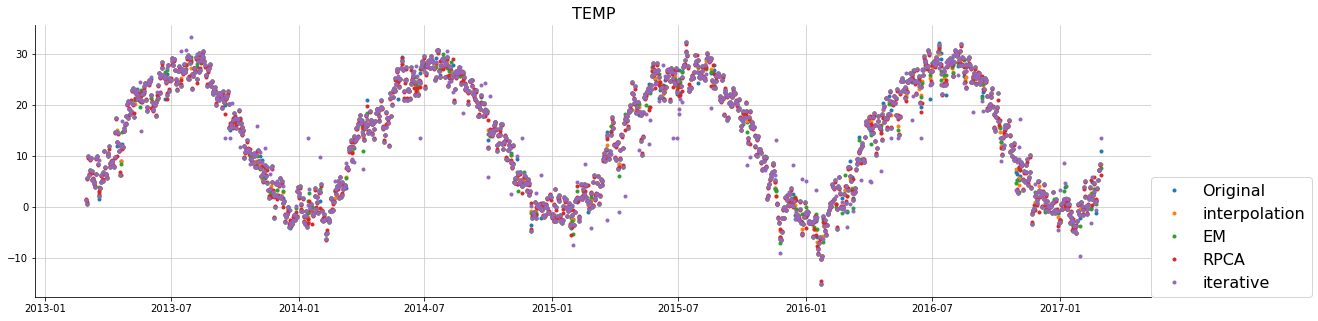

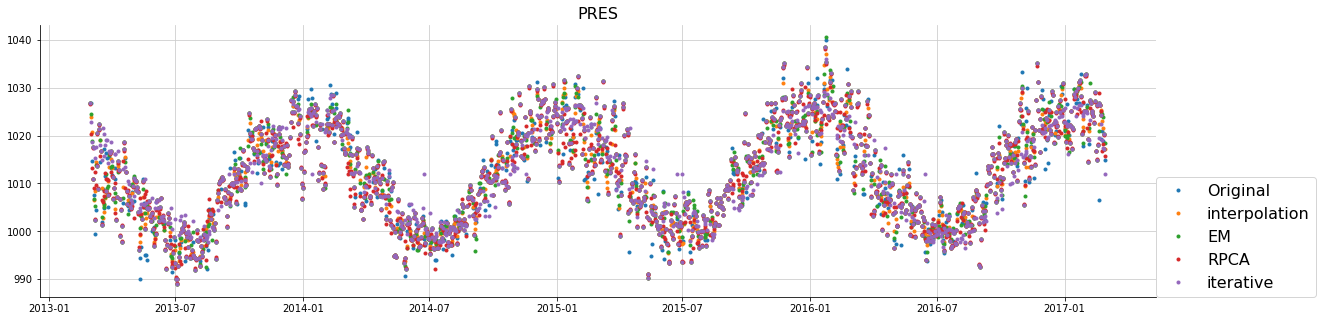

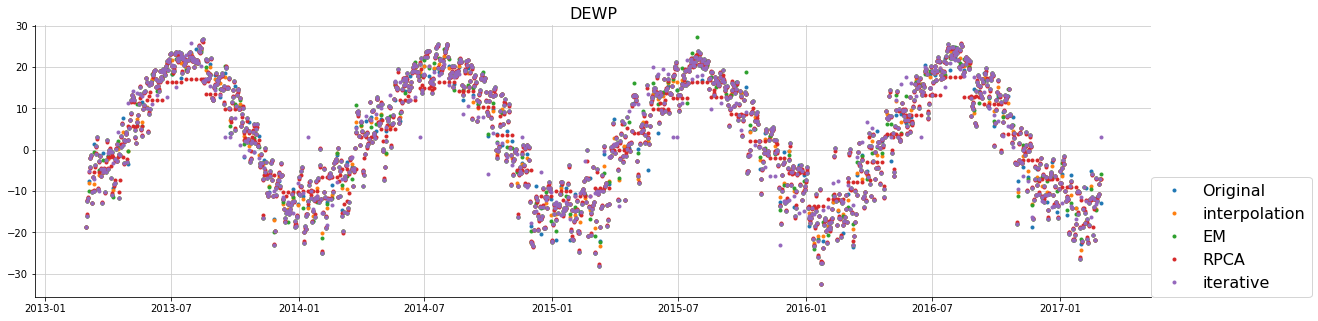

In [48]:
city = "Aotizhongxin"
for col in cols_to_impute:
    plt.figure(figsize=(20, 5))
    df = dataset.loc[city]
    
    plt.plot(df[col], ".", label="Original")
    for name, model in list(dict_models.items()):
        plt.plot(dfs_imputed[name].loc[city][col], ".", label=name)
    plt.title(col, fontsize=16)
    plt.legend(loc=[1, 0], fontsize=16)
    plt.show()

### **IV. Comparison of methods**

**IV.a. Covariance**

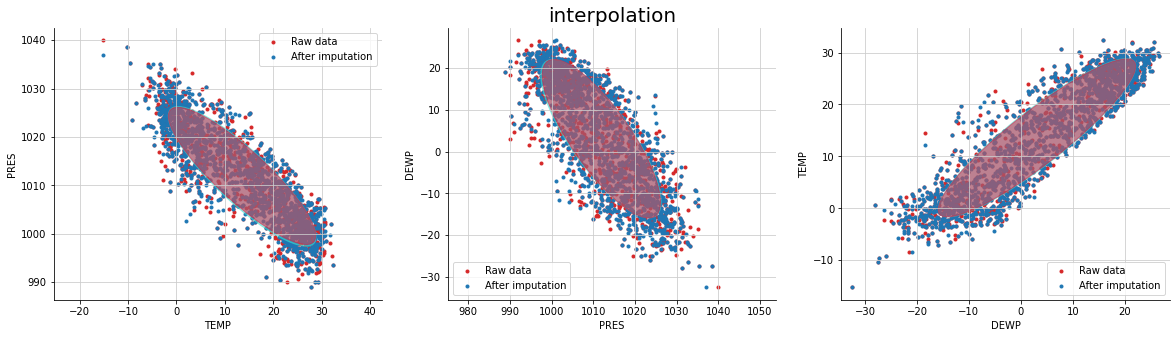

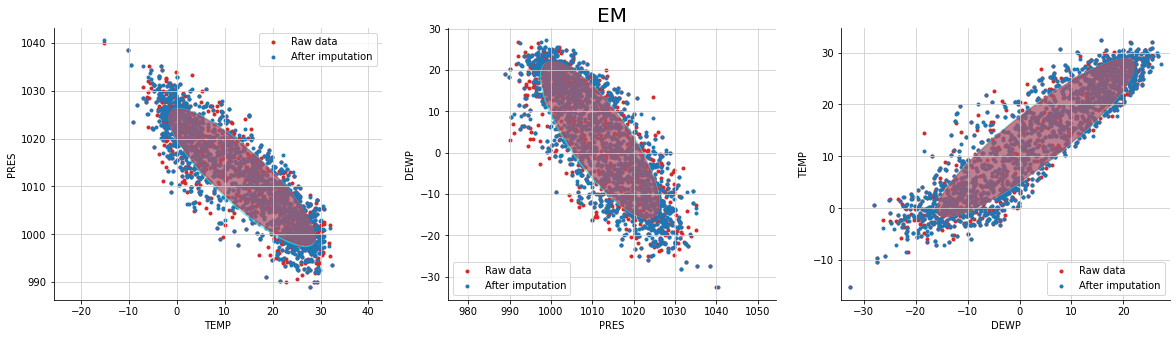

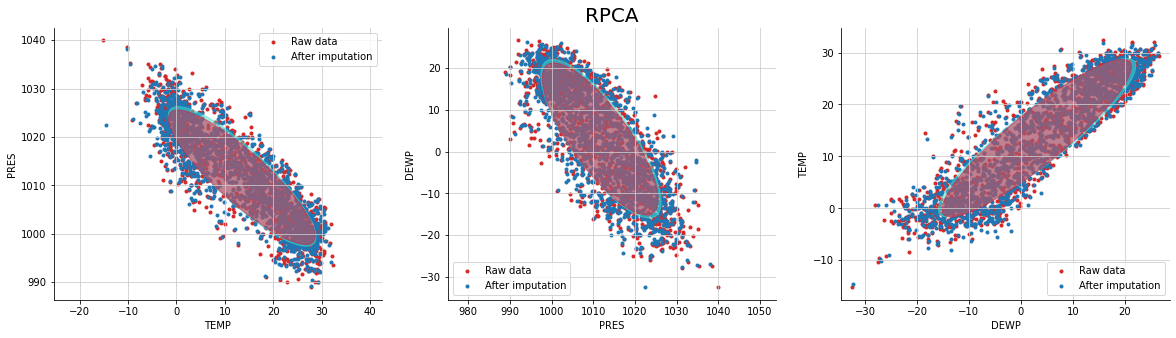

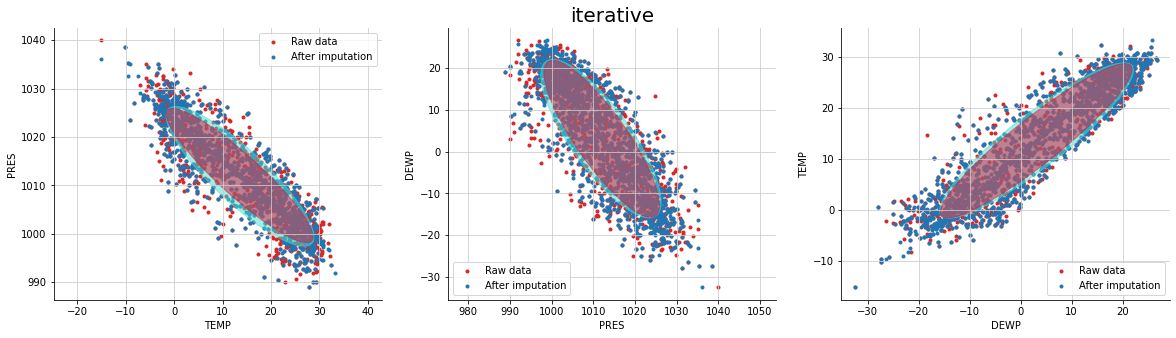

In [49]:
for imputation_method in dict_models.keys():
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    for i in range(3):
        data.compare_covariances(dataset.loc[city, cols_to_impute], dfs_imputed[imputation_method], cols_to_impute[i], cols_to_impute[(i+1)%3], axs[i])
        axs[1].set_title(f"{imputation_method}", fontsize=20)

**IV.b. Coefficient of determination**

In [50]:
from sklearn.metrics import r2_score
r2_scores = []
for name, df in dfs_imputed.items():
    r2_scores_ = []
    for col in cols_to_impute:
        r2_scores_.append(r2_score(dataset.loc[city, col].dropna(how="all"), df[col].ffill().bfill()))
    r2_scores.append(r2_scores_)
r2_scores = pd.DataFrame(r2_scores, index=dfs_imputed.keys(), columns=cols_to_impute)
r2_scores

,TEMP,PRES,DEWP
interpolation,0.996826,0.951616,0.992520
EM,0.995621,0.954840,0.991077
RPCA,0.993432,0.916878,0.971163
iterative,0.971431,0.900951,0.966923


**IV.b. Auto-correlation**

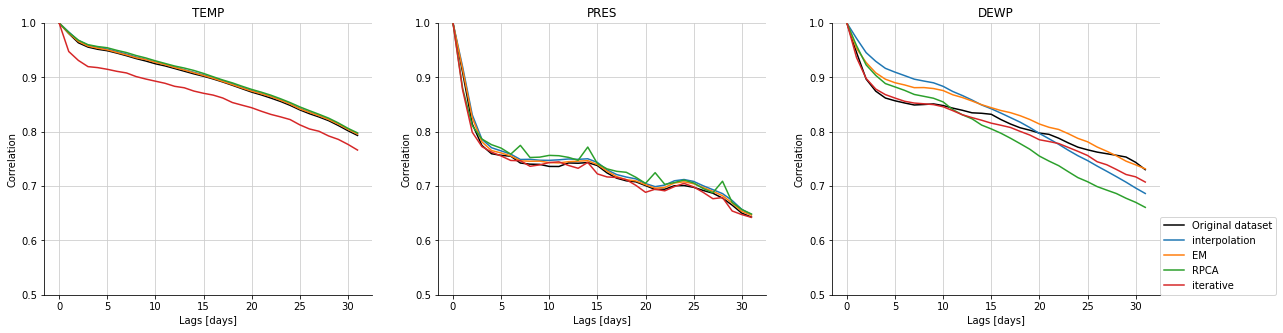

In [30]:
from statsmodels.tsa.stattools import acf
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, col in enumerate(cols_to_impute):
    axs[i].plot(acf(dataset.loc[city, col].dropna()), color="k")
    for name, df in dfs_imputed.items():
        axs[i].plot(acf(df[col]))
    axs[i].set_xlabel("Lags [days]")
    axs[i].set_ylabel("Correlation")
    axs[i].set_ylim([0.5, 1])
    axs[i].set_title(col)
axs[-1].legend(["Original dataset"] +  list(dfs_imputed.keys()), loc=[1, 0])

**IV.b. Distances between distributions**

In [54]:
kl_divergences = []
for name, df in dfs_imputed.items():
    kl_divergences_ = []
    for col in cols_to_impute:
        kl_divergences_.append(data.KL(dataset.loc[city, col].dropna(how="all"), df[col].ffill().bfill()))
    kl_divergences.append(kl_divergences_)
kl_divergences = pd.DataFrame(kl_divergences, index=dfs_imputed.keys(), columns=cols_to_impute)
kl_divergences

/Users/hlbotterman/virtualEnv/env_qolmat/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,TEMP,PRES,DEWP
interpolation,48.531773,-137.387365,-13.860795
EM,27.450193,-171.440779,27.333504
RPCA,141.358865,278.072168,-68.103198
iterative,301.018348,-247.506967,195.571805
